In [1]:
import tensorflow

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
import io

# ================= CONFIGURATION =================
INPUT_CSV = r'D:\FolderA\Datasets\feeds.csv' # Save your data to this file first
SEQ_LEN_IN = 30   # Input: Past 30 minutes
SEQ_LEN_OUT = 60  # Output: Next 60 minutes
FEATURES = 3      # Temp, Hum, Pressure
# =================================================

def create_dataset(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(data):
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y.flatten()) # Flatten output for Dense layer
    return np.array(X), np.array(y)

In [9]:
# 1. Load and Preprocess Data
# ---------------------------
# Assuming the CSV format you provided
df = pd.read_csv(INPUT_CSV)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.set_index('created_at')
df = df.drop(columns=['entry_id'])

# Resample to 1-minute intervals to handle irregular updates
df_resampled = df.resample('1T').mean().interpolate()
data = df_resampled.values

# Normalize data (CRITICAL for Neural Networks)
mean = data.mean(axis=0)
std = data.std(axis=0)
data_norm = (data - mean) / std

C:\Users\Rohan\AppData\Local\Temp\ipykernel_4588\3543926050.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample('1T').mean().interpolate()


In [10]:
print(f"MEAN: {mean}")
print(f"STD:  {std}")
print("\nCOPY THESE VALUES TO YOUR ARDUINO SKETCH:")
print(f"float MEANS[] = {{ {mean[0]:.4f}, {mean[1]:.4f}, {mean[2]:.4f} }};")
print(f"float STDS[]  = {{ {std[0]:.4f}, {std[1]:.4f}, {std[2]:.4f} }};")


MEAN: [  25.8489465    71.6868823  1014.33958428]
STD:  [1.83257482 8.24136102 1.50942803]

COPY THESE VALUES TO YOUR ARDUINO SKETCH:
float MEANS[] = { 25.8489, 71.6869, 1014.3396 };
float STDS[]  = { 1.8326, 8.2414, 1.5094 };


In [11]:
# Create Windows
X, y = create_dataset(data_norm, SEQ_LEN_IN, SEQ_LEN_OUT)

In [62]:
# 2. Build GRU Model
# ------------------
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQ_LEN_IN, FEATURES)),
    # GRU layer optimized for small footprint
    tf.keras.layers.GRU(48, return_sequences=False, unroll=True), 
    # Dense output: 60 steps * 3 features = 180 outputs
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(SEQ_LEN_OUT * FEATURES) 
])


In [63]:
model.compile(optimizer='adam', loss='mse')

# === ADDED: Early Stopping Callback ===
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',   # Watch the validation loss
    patience=5,           # Wait 5 epochs for improvement before stopping
    restore_best_weights=True, # IMPORTANT: Revert to the best model found
    verbose=1
)
model.fit(X, y, epochs=50, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

Epoch 1/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0772 - val_loss: 0.0409
Epoch 2/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0381 - val_loss: 0.0383
Epoch 3/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0346 - val_loss: 0.0502
Epoch 4/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0313 - val_loss: 0.0539
Epoch 5/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0282 - val_loss: 0.0725
Epoch 6/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0256 - val_loss: 0.0965
Epoch 7/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0222 - val_loss: 0.1078
Epoch 8/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0197 - val_loss: 0.1352
Epoch 9/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0178 - val_loss: 0.1603
Epoch 10/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0161 - val_loss: 0.1347
Epoch 11/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0149 - val_loss: 0.1294
Epoch 12/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms

Time   Temp (C)   Hum (%)    Pres (hPa)
----------------------------------------
+1m    26.91       64.63       1015.47
+11m    27.64       62.16       1015.56
+21m    28.10       60.25       1015.66
+31m    28.43       59.28       1015.81
+41m    28.45       59.12       1015.96
+51m    28.46       59.04       1016.04


C:\Users\Rohan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


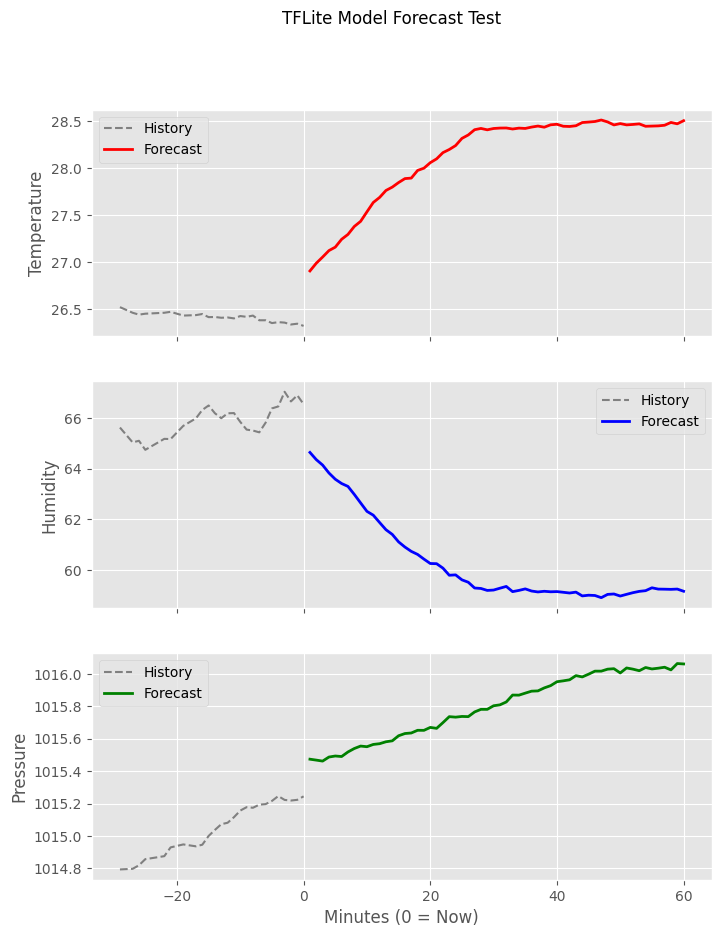

In [66]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# ================= CONFIGURATION =================
# COPY THESE FROM YOUR TRAIN SCRIPT OUTPUT
MEAN = np.array([25.8489465,71.6868823,1014.33958428])
STD  = np.array([1.83257482,8.24136102,1.50942803])
DATA_FILE = INPUT_CSV
# =================================================

# 1. Prepare Input Data (Last 30 minutes from file)
df = df_resampled

# Grab the last 30 entries
raw_input = df.values[-1200:-1170] 

if len(raw_input) < 30:
    raise ValueError(f"Not enough data! Need 30 rows, got {len(raw_input)}")

# Normalize
input_norm = (raw_input - MEAN) / STD
# Add batch dimension (1, 30, 3) and ensure float32
input_tensor = np.expand_dims(input_norm, axis=0).astype(np.float32)

# 2. Initialize TFLite Interpreter
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 3. Run Inference
interpreter.set_tensor(input_details[0]['index'], input_tensor)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])[0]

# 4. Process Results
# Reshape flat output back to (60, 3)
forecast_norm = output_data.reshape(60, 3)
# Denormalize
forecast = (forecast_norm * STD) + MEAN

# 5. Print & Plot
print(f"{'Time':<6} {'Temp (C)':<10} {'Hum (%)':<10} {'Pres (hPa)':<10}")
print("-" * 40)
for i in range(0, 60, 10): # Print every 10th minute
    vals = forecast[i]
    print(f"+{i+1}m    {vals[0]:.2f}       {vals[1]:.2f}       {vals[2]:.2f}")

# Simple Visualization
plt.style.use('ggplot')
fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

features = ['Temperature', 'Humidity', 'Pressure']
colors = ['red', 'blue', 'green']

for i in range(3):
    # Plot history
    ax[i].plot(range(-29, 1), raw_input[:, i], color='gray', label='History', linestyle='--')
    # Plot forecast
    ax[i].plot(range(1, 61), forecast[:, i], color=colors[i], label='Forecast', linewidth=2)
    ax[i].set_ylabel(features[i])
    ax[i].legend()

ax[2].set_xlabel('Minutes (0 = Now)')
plt.suptitle('TFLite Model Forecast Test')
plt.show()


In [58]:
len(df_resampled)

12988

# Conversion to tflite

In [64]:
# 3. Convert to TFLite for Microcontrollers
# -----------------------------------------

# A. Rebuild model with Static Batch & Unrolling
#    - batch_shape=(1, ...): Fixes dynamic shape issues
#    - unroll=True: Fixes "FlexTensorListReserve" / Flex Delegate errors
fixed_input = tf.keras.layers.Input(
    batch_shape=(1, SEQ_LEN_IN, FEATURES)
)

# Note: unroll=True increases file size slightly but guarantees compatibility
x = tf.keras.layers.GRU(48, return_sequences=False, unroll=True)(fixed_input)
x=tf.keras.layers.Dense(64)(x)
output = tf.keras.layers.Dense(SEQ_LEN_OUT * FEATURES)(x)

fixed_model = tf.keras.models.Model(fixed_input, output)
fixed_model.set_weights(model.get_weights())

# B. Convert without Flex Ops
converter = tf.lite.TFLiteConverter.from_keras_model(fixed_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] 

# We strictly want TFLite Builtins (No Flex Ops)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# (Optional) Check if we can disable the experimental flag safely now
# Usually unroll=True makes this flag irrelevant, but keeping it False is safer for RNNs
converter._experimental_lower_tensor_list_ops = False

try:
    tflite_model = converter.convert()
    print("Conversion Successful!")
except Exception as e:
    print(f"Conversion Failed: {e}")
    raise e

# 4. Save as C Header
output_dir = r'D:\FolderA\Saved_Models'

# A) Save the .tflite binary (Useful for Python testing/Netron)
tflite_path = f"{output_dir}\\weather_model.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"SUCCESS: Saved binary to {tflite_path}")

# B) Save as C Header (For Arduino)
def hex_to_c_array(data, var_name):
    hex_str = ', '.join([f'0x{b:02x}' for b in data])
    return f"""
#ifndef MODEL_H
#define MODEL_H
#include <cstdint>
#ifdef __has_attribute
#define ALIGN(x) __attribute__((aligned(x)))
#else
#define ALIGN(x)
#endif
ALIGN(16) const unsigned char {var_name}[] = {{ {hex_str} }};
const int {var_name}_len = {len(data)};
#endif
"""

header_path = f"{output_dir}\\model.h"
with open(header_path, 'w') as f:
    f.write(hex_to_c_array(tflite_model, 'weather_model_new'))

print(f"SUCCESS: Saved C header to {header_path}")
print(f"Model Size: {len(tflite_model)} bytes")


INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmpxgbdbvdw\assets


INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmpxgbdbvdw\assets


Saved artifact at 'C:\Users\Rohan\AppData\Local\Temp\tmpxgbdbvdw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 30, 3), dtype=tf.float32, name='keras_tensor_64')
Output Type:
  TensorSpec(shape=(1, 180), dtype=tf.float32, name=None)
Captures:
  2320490476944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2320490478864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2320490477520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2320490475024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2320490474640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2320490478480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2320490479440: TensorSpec(shape=(), dtype=tf.resource, name=None)
Conversion Successful!
SUCCESS: Saved binary to D:\FolderA\Saved_Models\weather_model.tflite
SUCCESS: Saved C header to D:\FolderA\Saved_Models\model.h
Model Size: 123512 bytes


# testing quantized vs normal

C:\Users\Rohan\AppData\Local\Temp\ipykernel_4588\3988211676.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.set_index('created_at').resample('1T').mean().interpolate()
C:\Users\Rohan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Time   Temp (C)   Hum (%)    Pres (hPa)
----------------------------------------
+1m    26.00       69.81       1011.80
+11m    26.08       69.39       1011.81
+21m    26.10       69.11       1011.84
+31m    26.01       69.48       1011.90
+41m    25.86       69.85       1011.79
+51m    25.82       70.19       1011.51


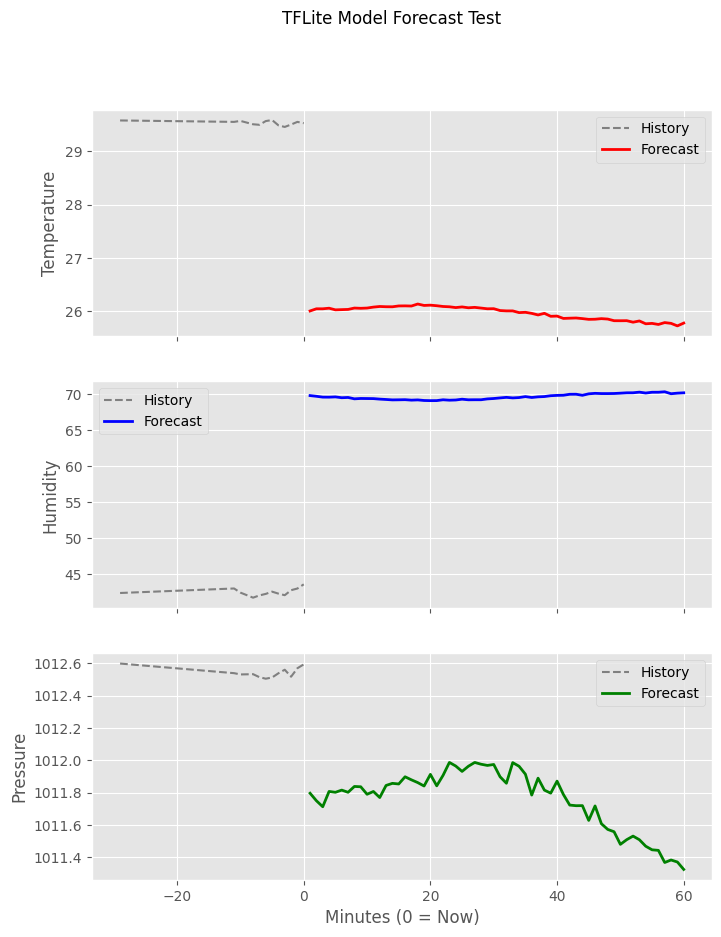

In [65]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# ================= CONFIGURATION =================
# COPY THESE FROM YOUR TRAIN SCRIPT OUTPUT
MEAN = np.array([24.8500, 76.1200, 1011.2000]) 
STD  = np.array([0.5000, 2.5000, 1.5000])
MODEL_PATH = 'D:\FolderA\Saved_Models\weather_model.tflite'
DATA_FILE = r'D:\FolderA\Datasets\feeds.csv'
# =================================================

# 1. Prepare Input Data (Last 30 minutes from file)
df = pd.read_csv(DATA_FILE)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.drop(columns=['entry_id'])
df = df.set_index('created_at').resample('1T').mean().interpolate()

# Grab the last 30 entries
raw_input = df.values[-30:] 

if len(raw_input) < 30:
    raise ValueError(f"Not enough data! Need 30 rows, got {len(raw_input)}")

# Normalize
input_norm = (raw_input - MEAN) / STD
# Add batch dimension (1, 30, 3) and ensure float32
input_tensor = np.expand_dims(input_norm, axis=0).astype(np.float32)

# 2. Initialize TFLite Interpreter
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 3. Run Inference
interpreter.set_tensor(input_details[0]['index'], input_tensor)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])[0]

# 4. Process Results
# Reshape flat output back to (60, 3)
forecast_norm = output_data.reshape(60, 3)
# Denormalize
forecast = (forecast_norm * STD) + MEAN

# 5. Print & Plot
print(f"{'Time':<6} {'Temp (C)':<10} {'Hum (%)':<10} {'Pres (hPa)':<10}")
print("-" * 40)
for i in range(0, 60, 10): # Print every 10th minute
    vals = forecast[i]
    print(f"+{i+1}m    {vals[0]:.2f}       {vals[1]:.2f}       {vals[2]:.2f}")

# Simple Visualization
plt.style.use('ggplot')
fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

features = ['Temperature', 'Humidity', 'Pressure']
colors = ['red', 'blue', 'green']

for i in range(3):
    # Plot history
    ax[i].plot(range(-29, 1), raw_input[:, i], color='gray', label='History', linestyle='--')
    # Plot forecast
    ax[i].plot(range(1, 61), forecast[:, i], color=colors[i], label='Forecast', linewidth=2)
    ax[i].set_ylabel(features[i])
    ax[i].legend()

ax[2].set_xlabel('Minutes (0 = Now)')
plt.suptitle('TFLite Model Forecast Test')
plt.show()


In [61]:
df_resampled.head(30)

,field1,field2,field3
created_at,,,
2024-10-16 15:11:00+05:30,25.395000,75.559570,1011.258420
2024-10-16 15:12:00+05:30,25.113333,74.991537,1011.252847
2024-10-16 15:13:00+05:30,24.873333,75.812173,1011.268717
2024-10-16 15:14:00+05:30,24.751667,76.150063,1011.253742
2024-10-16 15:15:00+05:30,24.630000,76.487953,1011.238767
2024-10-16 15:16:00+05:30,24.580000,76.947750,1011.207765
2024-10-16 15:17:00+05:30,24.600000,77.099120,1011.203430
2024-10-16 15:18:00+05:30,24.615000,77.345215,1011.202575
2024-10-16 15:19:00+05:30,24.642500,77.205325,1011.202542


In [72]:
import tensorflow as tf
import numpy as np

# ================= CONFIGURATION =================
# Point this to your saved Keras model file
OUTPUT_HEADER = r"D:\FolderA\Saved_Models\model_new.h"

SEQ_LEN_IN = 30
FEATURES = 3
SEQ_LEN_OUT = 60
# =================================================

print("Loading model...")

print("Rebuilding model structure for safety...")
# Rebuild to enforce batch_size=1 and unroll=True
safe_model = tf.keras.Sequential([
    tf.keras.layers.Input(batch_shape=(1, SEQ_LEN_IN, FEATURES)),
    # unroll=True is critical for TFLite Micro stability
    tf.keras.layers.GRU(48, return_sequences=False, unroll=True),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(SEQ_LEN_OUT * FEATURES)
])

# Copy trained weights
safe_model.set_weights(model.get_weights())

print("Converting to TFLite (Pure Float32)...")
converter = tf.lite.TFLiteConverter.from_keras_model(safe_model)

# CRITICAL CHANGE: Disable all optimizations
# This keeps weights as float32. Larger file, but prevents quantization NaNs.
converter.optimizations = [] 
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model = converter.convert()

# Save as C Header
def hex_to_c_array(data, var_name):
    hex_str = ', '.join([f'0x{b:02x}' for b in data])
    return f"""
#ifndef MODEL_H
#define MODEL_H
#include <cstdint>
#ifdef __has_attribute
#define ALIGN(x) __attribute__((aligned(x)))
#else
#define ALIGN(x)
#endif
ALIGN(16) const unsigned char {var_name}[] = {{ {hex_str} }};
const int {var_name}_len = {len(data)};
#endif
"""

with open(OUTPUT_HEADER, 'w') as f:
    f.write(hex_to_c_array(tflite_model, 'weather_model_new'))

print(f"SUCCESS: {OUTPUT_HEADER} generated. Size: {len(tflite_model)} bytes.")


Loading model...
Rebuilding model structure for safety...
Converting to TFLite (Pure Float32)...
INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmpzbzf8dmh\assets


INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmpzbzf8dmh\assets


Saved artifact at 'C:\Users\Rohan\AppData\Local\Temp\tmpzbzf8dmh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 30, 3), dtype=tf.float32, name='keras_tensor_74')
Output Type:
  TensorSpec(shape=(1, 180), dtype=tf.float32, name=None)
Captures:
  2320971136848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2320971132816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2320971131856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2320971136656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2320971131472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2320971135888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2320971134544: TensorSpec(shape=(), dtype=tf.resource, name=None)
SUCCESS: D:\FolderA\Saved_Models\model_new.h generated. Size: 182328 bytes.
